# Implementation of PI controller based on Wood-chip tank with PI controller - Techteach.no - Finn Haugen

[Link to source code for wood-chip](http://techteach.no/control/python/sim_pi_control_chiptank.py)

In [1]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [2]:
# %% Def of PI controller function:
def fun_pi_con(y_sp_k, y_k, u_i_km1, contr_params, dt):
    
    (Kc, Ti, u_man, u_min, u_max) = contr_params
    e_k = y_sp_k - y_k                        # Control error
    u_p_k = Kc*(y_sp_k - y_k)                 # P term
    u_i_k = u_i_km1 + (Kc*dt/Ti)*e_k          # I term
    u_i_min = u_min - u_man
    u_i_max = u_max - u_man
    u_i_k = np.clip(u_i_k, u_i_min, u_i_max)  # Anti windup (Limit ui)
    u_k = u_man + u_p_k + u_i_k               # PI term + man control
    u_k = np.clip(u_k, u_min, u_max)          # Limitation of control
    
    return (u_k, u_i_k)                       #Returns control signal and calculated I term

In [3]:
# define the model name and simulation parameters
fmu_filename = 'AirHeater.fmu'
start_time = 0.0
stop_time = 600.0
step_size = 1e-3
show_plot=True

In [4]:
# read the FMU model description
model_description = read_model_description(fmu_filename)

In [5]:
# collect the value references from the FMU
vrs = {}
for variable in model_description.modelVariables:
    vrs[variable.name] = variable.valueReference
print(vrs)

{'T_CONST': 100663296, 'T_DELAY': 100663297, 'Kh': 100663298, 'u_ext': 352321536, 'T_amb_ext': 352321537, 'T_Out_ext': 335544320, 'der(T_Out_ext)': 369098755, '_StatesForOutputs.T_Out_ext': 33554432, 'der(_StatesForOutputs.T_Out_ext)': 318767104, 'CPUtime': 67108865, 'EventCounter': 67108866}


In [6]:
# get the value references for the variables we want to get/set
fmu_ControlSignal_Input = vrs['u_ext']                 # Control signal
fmu_AmbientTemperature_Input = vrs['T_amb_ext']        # Ambiente air temperature
fmu_OutputTemperature_Output = vrs['T_Out_ext']        # Output temperature from air heater

In [7]:
# extract the FMU
unzipdir = extract(fmu_filename)

fmu = FMU2Slave(guid = model_description.guid,
                unzipDirectory=unzipdir,
                modelIdentifier=model_description.coSimulation.modelIdentifier,
                instanceName='instance1')

# initialize simulation with FMU
fmu.instantiate()
fmu.setupExperiment(startTime=start_time)
fmu.enterInitializationMode()
fmu.exitInitializationMode()

time = start_time

rows = []  # list to record the results from simulation

#Parameters for the PID controller
dt = step_size          # time-step
setpoint = 20.0         # Process setpoint
initIterm = 0.0         # Initial value of the I term
prevIterm = initIterm   # Write the initial value to the loop variable

# Set up the control parameter tuple
Kp = 1.56               # Proportional gains for P-term
Ti = 12.0               # Integrator gains for I-term
uMan = 0.0
MinControlSignal = 0.0  # Minimum control signal
MaxControlSignal = 5.0  # Maximum control signal
contr_params = (Kp, Ti, uMan, MinControlSignal, MaxControlSignal)

# Initial simulation conditions
AmbienteTemperature = 20.0
InitialControlSignal = 0.0

# Set the initial values in the FMU variable definitions
fmu.setReal([fmu_ControlSignal_Input], [InitialControlSignal])
fmu.setReal([fmu_AmbientTemperature_Input], [AmbienteTemperature])

## Simulation

In [8]:
# simulation loop
while time < stop_time:

    # NOTE: the FMU.get*() and FMU.set*() functions take lists of
    # value references as arguments and return lists of values 
    
    # Step change in ambiente temperature after 100 seconds
    if time > 100: 
        AmbienteTemperature = 18
    
    # Step change in setpoint after 200 seconds
    if time > 200: 
        setpoint = 25
    
    # perform one step
    fmu.doStep(currentCommunicationPoint=time, communicationStepSize=step_size)

    # advance the time
    time += step_size

    # get the values for 'inputs' and 'outputs'
    inputs, outputs, AmbTemp = fmu.getReal([fmu_ControlSignal_Input, fmu_OutputTemperature_Output, fmu_AmbientTemperature_Input])

    # append the results for plotting
    rows.append((time, inputs, outputs, AmbTemp))
    
    (controlSignal, u_i_k) = fun_pi_con(setpoint, outputs, prevIterm, contr_params, dt)

    fmu.setReal([fmu_ControlSignal_Input], [controlSignal])
    fmu.setReal([fmu_AmbientTemperature_Input], [AmbienteTemperature])
    
    # Update integral term
    prevIterm = u_i_k

# Terminate the simulation object
fmu.terminate()
fmu.freeInstance()

# clean up
shutil.rmtree(unzipdir, ignore_errors=True)

In [9]:
# Convert the results to a structured NumPy array
result = np.array(rows, dtype=np.dtype([('time', np.float64), ('inputs', np.float64), ('outputs', np.float64), ('AmbTemp', np.float64)]))

# Write results to .csv file
csv_filename = "datafiles/airHeaterPIDsimulation.csv"
np.savetxt(csv_filename, result, delimiter=',', header="time,controlSignal,outputTemperature,ambienteTemperature")

## Plotting

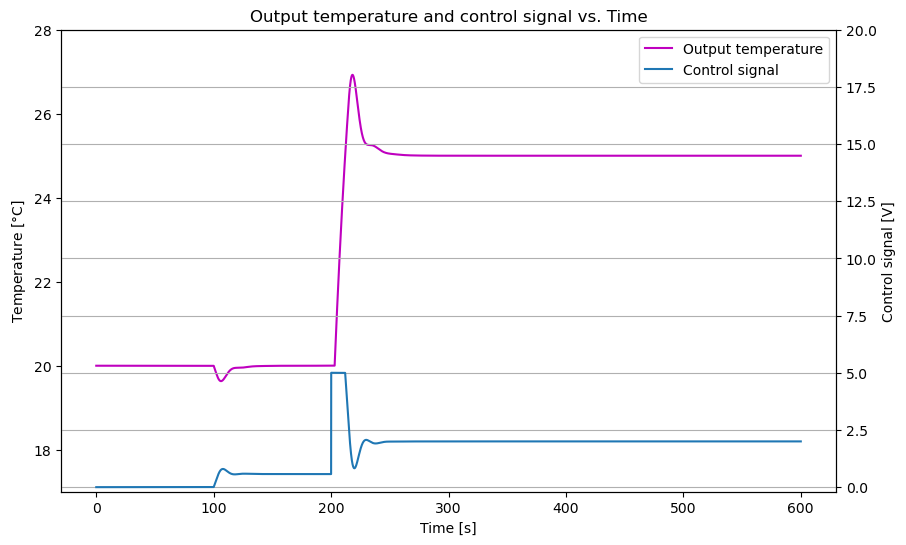

In [25]:
# Extract data from the result array
time = result['time']
inputs = result['inputs']
outputs = result['outputs']

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first variable (Output temperature) on the first y-axis (ax1)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel((r'Temperature [$\degree$C]'))
ax1.plot(time, outputs, 'm', label='Output temperature')
ax1.tick_params(axis='y')

# Set the y-axis limits for the output temperature subplot
ax1.set_ylim(17, 28)

# Create a second y-axis (ax2) for the second variable (Control signal)
ax2 = ax1.twinx()  # Share the same x-axis
ax2.set_ylabel('Control signal [V]')
ax2.plot(time, inputs, label='Control signal')
ax2.tick_params(axis='y')

# Set the y-axis limits for the control signal subplot
ax2.set_ylim(-0.2, 20)

# Customize the plot
plt.title('Output temperature and control signal vs. Time')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True)

# Save a copy of the plot
plt.savefig('plots/FMUairHeaterPID.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()